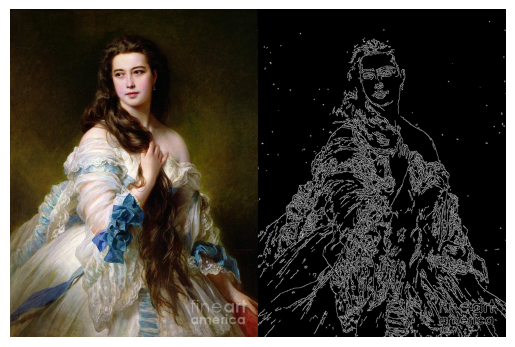

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from diffusers.utils import load_image
from PIL import Image

image_file = "https://images.fineartamerica.com/images/artworkimages/mediumlarge/1/portrait-of-madame-rimsky-korsakov-franz-xaver-winterhalter.jpg"
original_image = load_image(image_file)

def get_canny_image(original_image, low_threshold=100, high_threshold=200):
  image = np.array(original_image)

  image = cv2.Canny(image, low_threshold, high_threshold)
  image = image[:, :, None]
  image = np.concatenate([image, image, image], axis=2)
  canny_image = Image.fromarray(image)
  return canny_image

canny_image = get_canny_image(original_image)

def display_images(image1, image2):
  # Combine the images horizontally
  combined_image = Image.new('RGB', (image1.width + image2.width, max(image1.height, image2.height)))
  combined_image.paste(image1, (0, 0))
  combined_image.paste(image2, (image1.width, 0))
  # Display the combined image
  plt.imshow(combined_image)
  plt.axis('off')
  plt.show()

display_images(original_image, canny_image)


In [2]:
from diffusers import StableDiffusionControlNetPipeline, ControlNetModel
import torch

controlnet = ControlNetModel.from_pretrained("lllyasviel/sd-controlnet-canny", torch_dtype=torch.float16)
pipe = StableDiffusionControlNetPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5", controlnet=controlnet, torch_dtype=torch.float16
)

pipe.enable_model_cpu_offload()
pipe.enable_xformers_memory_efficient_attention()


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.


In [3]:
prompt = ", best quality, extremely detailed"
prompt = [t + prompt for t in ["Audrey Hepburn", "Elizabeth Taylor", "Scarlett Johansson", "Taylor Swift"]]
generator = [torch.Generator(device="cpu").manual_seed(42) for i in range(len(prompt))]

output = pipe(
    prompt,
    canny_image,
    negative_prompt=["monochrome, lowres, bad anatomy, worst quality, low quality"] * 4,
    num_inference_steps=20,
    generator=generator,
)


  0%|          | 0/20 [00:00<?, ?it/s]

In [2]:
import matplotlib.pyplot as plt

def draw_image_grids(images, rows, cols):
  # Create a rows x cols grid for displaying the images
  fig, axes = plt.subplots(2, 2, figsize=(10, 10))

  for row in range(rows):
    for col in range(cols):
      axes[row, col].imshow(images[col + row * cols])
  for ax in axes.flatten():
      ax.axis('off')
  # Display the grid
  plt.show()


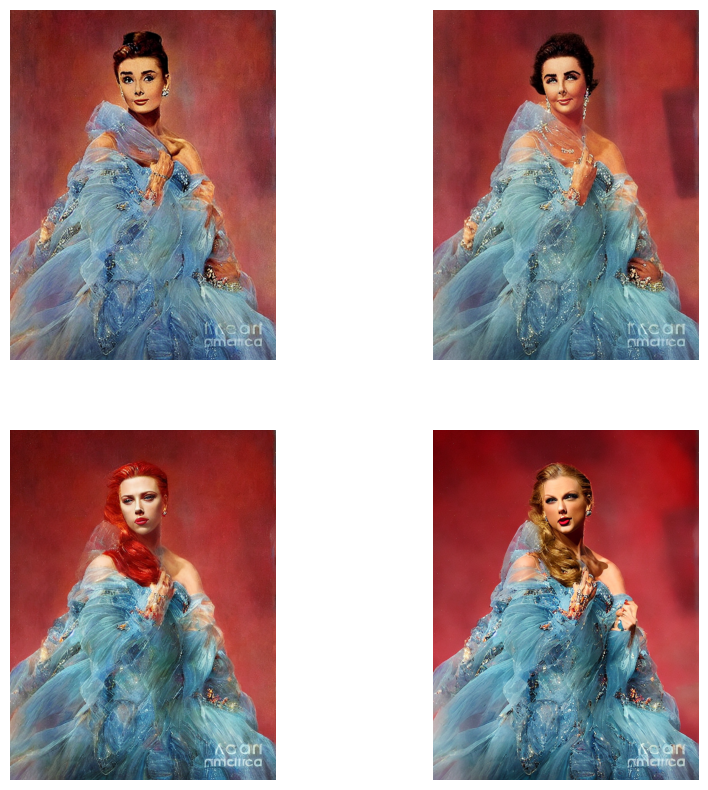

In [5]:
draw_image_grids(output.images, 2, 2)


/home/fw/miniconda3/envs/ai_aesthetics/lib/python3.10/site-packages/controlnet_aux/mediapipe_face/mediapipe_face_common.py:7: UserWarning: The module 'mediapipe' is not installed. The package will have limited functionality. Please install it using the command: pip install 'mediapipe'
  warnings.warn(
/home/fw/miniconda3/envs/ai_aesthetics/lib/python3.10/site-packages/controlnet_aux/segment_anything/modeling/tiny_vit_sam.py:654: UserWarning: Overwriting tiny_vit_5m_224 in registry with controlnet_aux.segment_anything.modeling.tiny_vit_sam.tiny_vit_5m_224. This is because the name being registered conflicts with an existing name. Please check if this is not expected.
  return register_model(fn_wrapper)
/home/fw/miniconda3/envs/ai_aesthetics/lib/python3.10/site-packages/controlnet_aux/segment_anything/modeling/tiny_vit_sam.py:654: UserWarning: Overwriting tiny_vit_11m_224 in registry with controlnet_aux.segment_anything.modeling.tiny_vit_sam.tiny_vit_11m_224. This is because the name bei

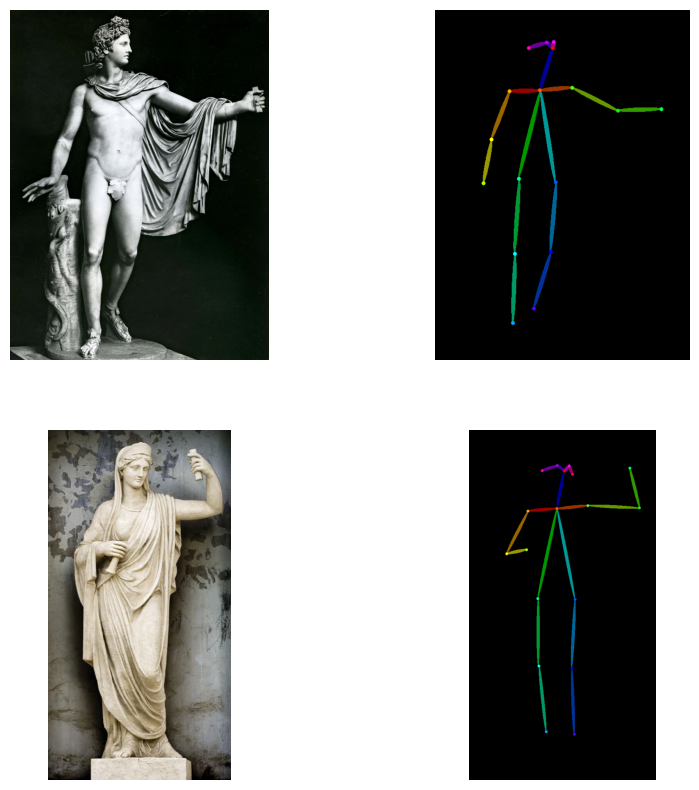

In [6]:
from controlnet_aux import OpenposeDetector
from diffusers.utils import load_image

openpose = OpenposeDetector.from_pretrained("lllyasviel/ControlNet")

image_file1 = "https://media.discordapp.net/attachments/1092064974794391644/1181600338277576714/apllo.png"
original_image1 = load_image(image_file1)
openpose_image1 = openpose(original_image1)

image_file2 = "https://media.discordapp.net/attachments/1092064974794391644/1181600338680221716/athene.png"
original_image2 = load_image(image_file2)
openpose_image2 = openpose(original_image2)

images = [original_image1, openpose_image1, original_image2, openpose_image2]
draw_image_grids(images, 2, 2)


In [7]:
from diffusers import StableDiffusionControlNetPipeline, ControlNetModel
from diffusers import UniPCMultistepScheduler
import torch

controlnet = ControlNetModel.from_pretrained(
    "fusing/stable-diffusion-v1-5-controlnet-openpose", torch_dtype=torch.float16
)
pipe = StableDiffusionControlNetPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5",
    controlnet=controlnet,
    torch_dtype=torch.float16,
)
pipe.scheduler = UniPCMultistepScheduler.from_config(pipe.scheduler.config)
pipe.enable_model_cpu_offload()
pipe.enable_xformers_memory_efficient_attention()


config.json:   0%|          | 0.00/920 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/1.45G [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.


In [12]:
poses = [openpose_image1, openpose_image2, openpose_image1, openpose_image2]

generator = [torch.Generator(device="cpu").manual_seed(42) for i in range(4)]
prompt1 = "captain america character, best quality, extremely detailed"
prompt2 = "hulk character, best quality, extremely detailed"

output = pipe(
    [prompt1, prompt1, prompt2, prompt2],
    poses,
    negative_prompt=["monochrome, lowres, bad anatomy, worst quality, low quality"] * 4,
    generator=generator,
    num_inference_steps=20,
)


  0%|          | 0/20 [00:00<?, ?it/s]

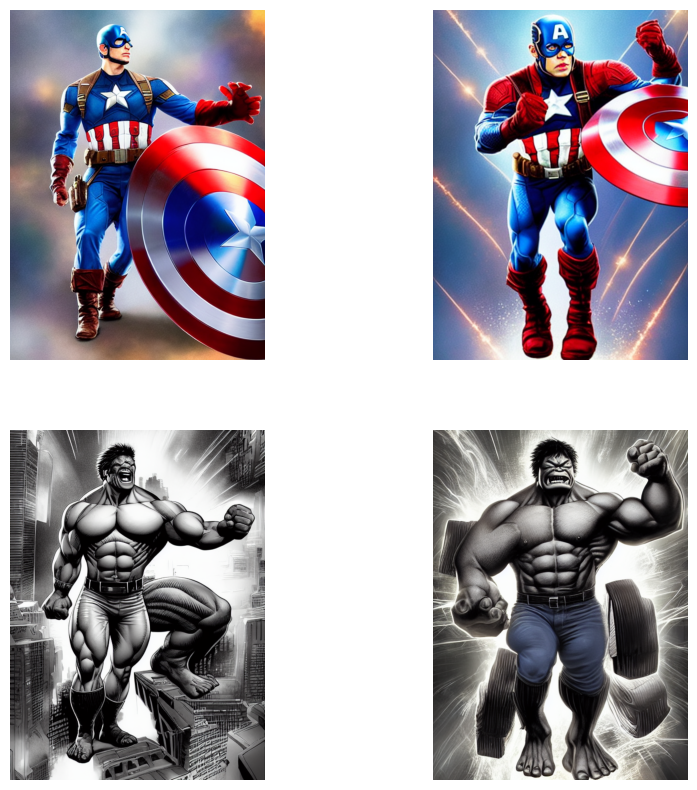

In [13]:
draw_image_grids(output.images, 2, 2)


In [1]:
from diffusers import StableDiffusionControlNetPipeline, ControlNetModel
from diffusers import UniPCMultistepScheduler
import torch

controlnet = ControlNetModel.from_pretrained(
    "lllyasviel/sd-controlnet-scribble", torch_dtype=torch.float16
)
pipe = StableDiffusionControlNetPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5",
    controlnet=controlnet,
    torch_dtype=torch.float16,
)
pipe.enable_model_cpu_offload()
pipe.enable_xformers_memory_efficient_attention()


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.


In [3]:
from diffusers.utils import load_image

image_file = "https://en.pimg.jp/059/724/790/1/59724790.jpg"
scribble_image = load_image(image_file)

generator = [torch.Generator(device="cpu").manual_seed(2) for i in range(4)]
prompt = "cat"
prompt = [prompt + t for t in [" in a room", " near the lake", " on the street", " in the forrest"]]
output = pipe(
    prompt,
    scribble_image,
    negative_prompt=["lowres, bad anatomy, worst quality, low quality"] * 4,
    generator=generator,
    num_inference_steps=50,
)


  0%|          | 0/50 [00:00<?, ?it/s]

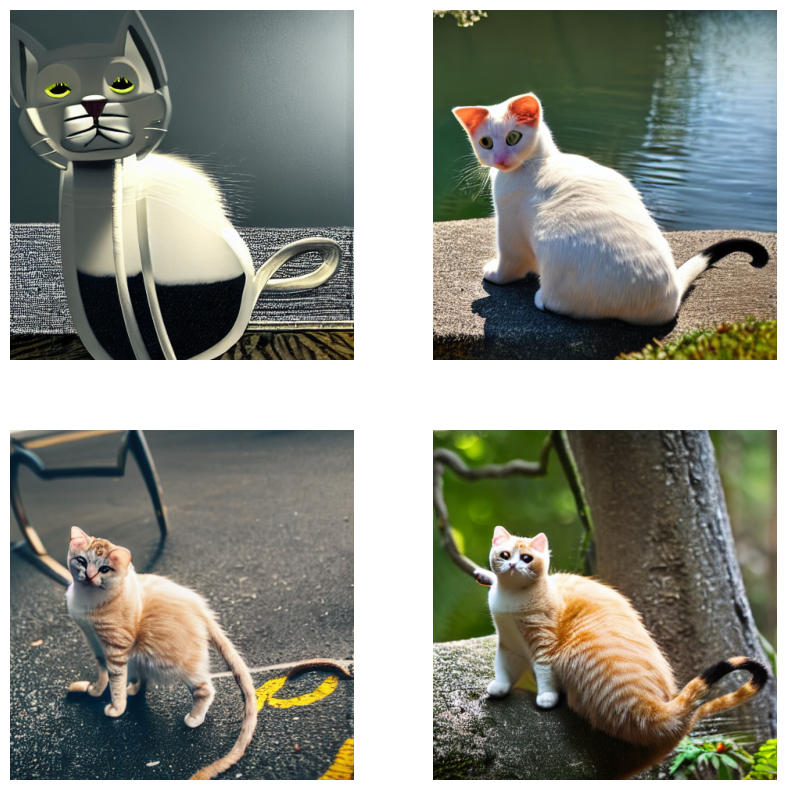

In [4]:
draw_image_grids(output.images, 2, 2)
